In [420]:
import numpy as np
import cv2
from sklearn.cluster import KMeans
from collections import Counter
import imutils
from matplotlib import pyplot as plt
from skimage import measure
from skimage.measure import regionprops
import matplotlib.patches as patches
import warnings
warnings.simplefilter('ignore')
import math

In [421]:
# FUNCTIONS

def sharpenImage(image):
    kernel = np.array([[-1,-1,-1], 
                       [-1, 9,-1],
                       [-1,-1,-1]])
    return cv2.filter2D(image, -1, kernel)

def cropPart(img, x,y,w,h):
    y0 = y
    x0 = x
    y1 = (int)(y0+w)
    x1 = (int)(x0+h)
    return img[y0:y1, x0:x1]

def getColorInformation(estimator_labels, estimator_cluster, hasThresholding=False):

    # Variable to keep count of the occurance of each color predicted
    occurance_counter = None

    # Output list variable to return
    colorInformation = []

    # Check for Black
    hasBlack = False

    # If a mask has be applied, remove th black
    if hasThresholding == True:

        (occurance, cluster, black) = removeBlack(
            estimator_labels, estimator_cluster)
        occurance_counter = occurance
        estimator_cluster = cluster
        hasBlack = black

    else:
        occurance_counter = Counter(estimator_labels)

    # Get the total sum of all the predicted occurances
    totalOccurance = sum(occurance_counter.values())

    # Loop through all the predicted colors
    for x in occurance_counter.most_common(len(estimator_cluster)):

        index = (int(x[0]))

        # Quick fix for index out of bound when there is no threshold
        index = (index-1) if ((hasThresholding & hasBlack)
                              & (int(index) != 0)) else index

        # Get the color number into a list
        color = estimator_cluster[index].tolist()

        # Get the percentage of each color
        color_percentage = (x[1]/totalOccurance)

        # make the dictionay of the information
        colorInfo = {"cluster_index": index, "color": color,
                     "color_percentage": color_percentage}

        # Add the dictionary to the list
        colorInformation.append(colorInfo)

    return colorInformation


def extractDominantColor(image, number_of_colors=5, hasThresholding=False):

    # Quick Fix Increase cluster counter to neglect the black(Read Article)
    if hasThresholding == True:
        number_of_colors += 1

    # Taking Copy of the image
    img = image.copy()

    # Convert Image into RGB Colours Space
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Reshape Image
    img = img.reshape((img.shape[0]*img.shape[1]), 3)

    # Initiate KMeans Object
    estimator = KMeans(n_clusters=number_of_colors, random_state=0)

    # Fit the image
    estimator.fit(img)

    # Get Colour Information
    colorInformation = getColorInformation(
        estimator.labels_, estimator.cluster_centers_, hasThresholding)
    return colorInformation

# Extract the percentage of white and of black
def getPercents(dom):
    th = 5
    white = 0
    others = 0
    for c in dom:
        blacking = []
        x = c["color"]
        if x[0] < th and x[1] < th and x[2] < th:
            others += c["color_percentage"]
        else:
            white += c["color_percentage"]
    return {"w":white, "b": others}

def isOverlaping(a, b):
    if((b[0] > a[0] and b[0] < a[2])and(b[2] > a[0] and b[2] < a[2])
       or
       (b[1] > a[1] and b[1] < a[3])and(b[3] > a[1] and b[3] < a[3])):
        return True
    else:
        return False

def checkOverlaps(regions, check):
    for area in regions:
        if(isOverlaping(area, check) and isOverlaping(check, area)):
            return True
    return False

# Check if two areas are overlapping


# Get the dominance colors of image segment and 
# return the white/black ratio
# higher black of 65% or more indicate selected option
def getSelected(img):
    dominantColors = extractDominantColor(img)
    p = getPercents(dominantColors)
    return p




def isCorrect(answers, selected, pos):
    if(answers[pos] == selected):
        return [True, (0, 204, 0)]
    else:
        return [False, (255, 0, 0)]
    
def getCorrectAnswer(answers, pos):
    if(pos < len(answers)):
        letters = ["A", "B", "C", "D"]
        tf = [True, False]
        ans = answers[pos]
        if(ans in letters):
            return letters.index(ans)
        elif(ans in tf):
            return tf.index(ans)
        else:
            return -1
    else:
        return -1

    
def calculateIntersection(a0, a1, b0, b1):
    if a0 >= b0 and a1 <= b1: # Contained
        intersection = a1 - a0
    elif a0 < b0 and a1 > b1: # Contains
        intersection = b1 - b0
    elif a0 < b0 and a1 > b0: # Intersects right
        intersection = a1 - b0
    elif a1 > b1 and a0 < b1: # Intersects left
        intersection = b1 - a0
    else: # No intersection (either side)
        intersection = 0

    return intersection

def checkOverpping(rectangles, interest):
    X0, Y0, X1, Y1, = interest
    AREA = float((X1 - X0) * (Y1 - Y0))

    # Rectangles to check
    rectangles = rectangles
    # Intersecting rectangles:
    intersecting = []
    for x0, y0, x1, y1 in rectangles:       
        width = calculateIntersection(x0, x1, X0, X1)        
        height = calculateIntersection(y0, y1, Y0, Y1)        
        area = width * height
        percent = area / AREA
        if (percent > 0):
            return True
    return False

In [430]:
def getSelectedOption(img, ans):
    label_image = measure.label(img.copy(), background=1)
    optionPicker = []
    register = []

    areaHeight = label_image.shape[0]
    areaWidth = label_image.shape[1]
    for region in regionprops(label_image):
        # the bounding box coordinates
        minRow, minCol, maxRow, maxCol = region.bbox
        detector = (maxCol - minCol)/(maxRow - minRow)
        areaWidth_i = maxCol - minCol
        areaHeight_i = maxRow - minRow
        if(minCol > (areaHeight*0.65) and areaWidth_i > (0.1 * areaWidth) and areaWidth_i < (0.2 * areaWidth)  and region.area > 20 and detector > 0.4 and detector < 2.5 and not checkOverpping(register, (minRow, minCol, maxRow, maxCol))):
            register.append((minRow, minCol, maxRow, maxCol))
            box = cropPart(img.copy(), minCol, minRow, areaHeight_i,  areaWidth_i)
            data = getSelected(box)
            distance = math.sqrt(minCol**2 + minRow**2)
            optionPicker.append({"shade": data["b"], "noshade": data["w"], "distance": distance, "box": (minRow, minCol, areaHeight_i,  areaWidth_i)})
            
    newlist = sorted(optionPicker, key=lambda k: k['distance']) 
    optionId = max(range(len(newlist)), key=lambda index: newlist[index]['shade'])
#     print(optionId)
    selected = newlist[optionId]
    correction = newlist[ans]
#     plt.show()
    return {"shaded": selected, "correct": correction, "got_it": optionId == ans};



def markSelections(boxes, ans, img):
    total = 0
    correct = 0
    
    for i, box in enumerate(boxes):
        total += 1
        data = getSelectedOption(box['img'], ans['q'+str(i+1)])
        correction = data['correct']
        shaded = data['shaded']
        
        color = (0,255,0)
        if(data['got_it']):
            correct += 1
            color = (255,0,0)
        
        CstartPointX = correction['box'][1] + box['start'][0]
        CstartpointY = correction['box'][0] + box['start'][1]
        Cheight = correction['box'][2]
        Cwidth = correction['box'][3]
        cv2.rectangle(img, (CstartPointX, CstartpointY), (CstartPointX+Cwidth, CstartpointY+Cheight), (0,0,255), 2)
        
        SstartPointX = shaded['box'][1] + box['start'][0]
        SstartpointY = shaded['box'][0] + box['start'][1]
        Sheight = shaded['box'][2]
        Swidth = shaded['box'][3]
        cv2.rectangle(img, (SstartPointX, SstartpointY), (SstartPointX+Swidth, SstartpointY+Cheight), color, 2)
        
    return {'total': total, 'correct': correct, 'image': img}

In [423]:
# PROCESSING
img = imutils.url_to_image("http://localhost/images/ppm/sheet8.png")
img = imutils.resize(img, width=600)
gray_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
sharpImg = sharpenImage(gray_image)
thresh, bw_imgX = cv2.threshold(sharpImg, 185, 255, cv2.THRESH_BINARY)

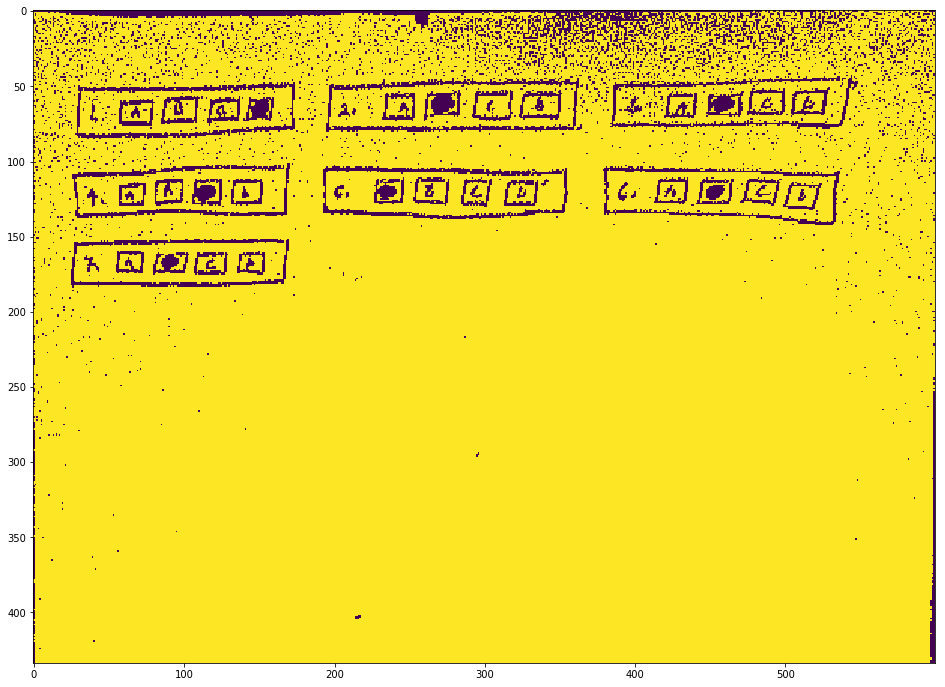

In [424]:
plt.subplots(1,1, sharex='col', sharey='row', figsize=(24,12))
plt.imshow(bw_imgX)

In [428]:
bw_img = cv2.Canny(gray_image.copy(), 20, 255)
binary_sheet = bw_img
label_image = measure.label(binary_sheet, background=1)
register = []
interestAreas = []
register = []
shape = label_image.shape

# regionprops creates a list of properties of all the labelled regions
for region in regionprops(label_image):
    if region.area < 150 or region.area > 1200:
        continue
        
    minRow, minCol, maxRow, maxCol = region.bbox
    areaWidth = maxCol - minCol
    areaHeight = maxRow - minRow
    if(areaWidth/areaHeight > 3 and areaHeight/areaWidth > 0.1 and areaWidth > (shape[1] * 0.2) and areaWidth < (shape[1] * 0.333) and not checkOverpping(register, (minRow, minCol, maxRow, maxCol))):
        register.append((minRow, minCol, maxRow, maxCol))
        interestAreas.append({'img': cropPart(bw_imgX.copy(), minCol, minRow, maxRow-minRow,  maxCol-minCol), 'minR': minRow, 'minC': minCol, 'start': (minCol, minRow)})

interestAreas = sorted(interestAreas, key=lambda k: k['minR'])
chunks = [interestAreas[x:x+3] for x in range(0, len(interestAreas), 3)]

reArranged = []
for i, section in enumerate(chunks):  
    reArranged = reArranged + sorted(section, key=lambda k: k['minC'])




Marked:  6  out of  7


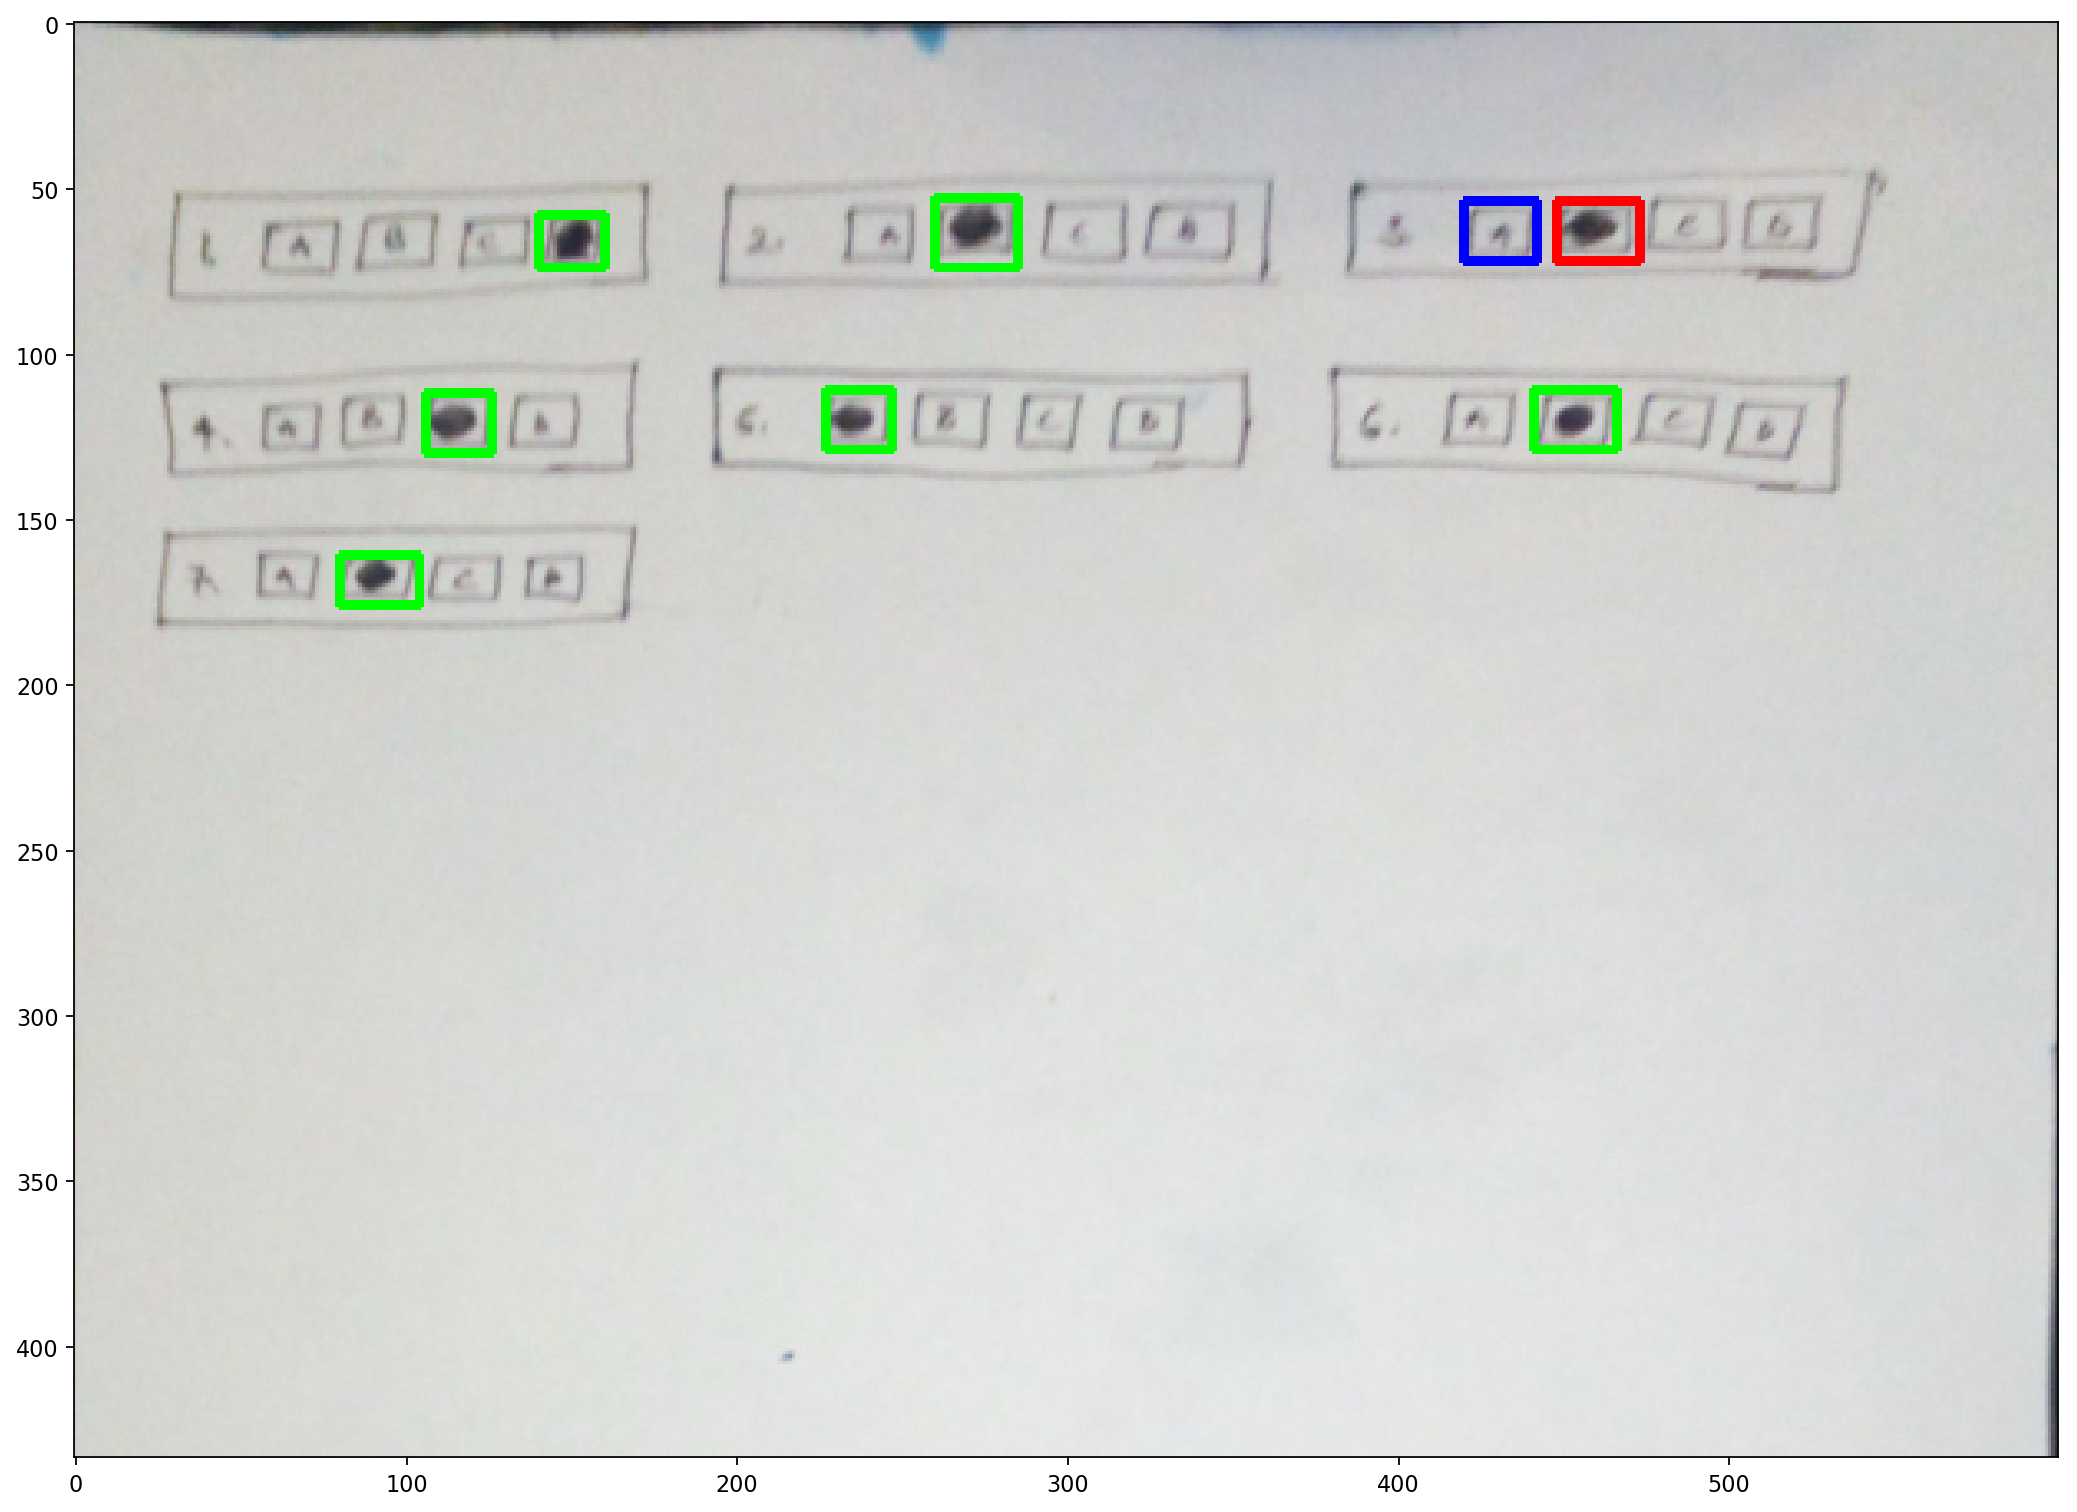

In [429]:
ans = {'q1': 3, 'q2': 1, 'q3':0, 'q4': 2, 'q5': 0, 'q6': 1, 'q7': 1}
mark = markSelections(reArranged, ans, img.copy())

print("Marked: ", mark['correct'], ' out of ', mark['total'])
plt.subplots(1, figsize=(16, 12), dpi=160 )
plt.imshow(mark['image'])